<a href="https://colab.research.google.com/github/j1ayizhao/datascienceA2/blob/main/JiayZhaoUnit8Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Project: Writing a BARTical


For my project I used a dataset from UC Irvine that contains important attributes of the garment industry, with the goal of predicting the productivity of garment employees.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart
import pymc_bart as pmb

In [3]:
garments = pd.read_csv('https://raw.githubusercontent.com/j1ayizhao/datascienceA2/refs/heads/main/productivity%20-%20garments_worker_productivity.csv')

In [4]:
garments

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
750,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
751,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
752,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


## Variable Selection

When making my causal diagram, I thought the most important predictors would be smv ("a measure used in the garment industry to estimate the time required to perform a specific operation or task in the production of a garment."), incentive, targeted productivity, number of workers (on the same task). So I decided to plot those to see which ones are the most associated with productivity. I also color coded the points based on department (sewing/finishing) to get a more nuanced read on the relationship.

<Axes: xlabel='incentive', ylabel='actual_productivity'>

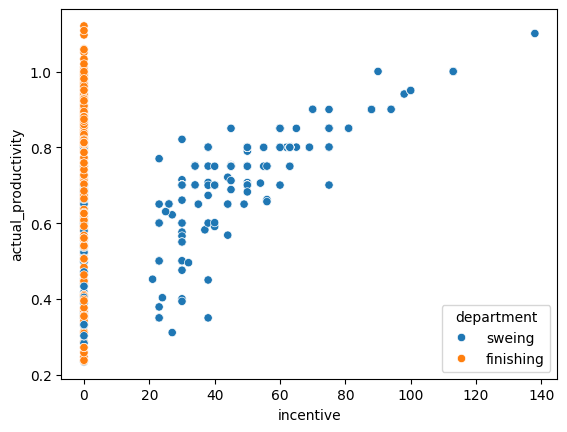

In [ ]:
sns.scatterplot(data = garments, y = 'actual_productivity', x = 'incentive', hue = 'department')

<Axes: xlabel='smv', ylabel='actual_productivity'>

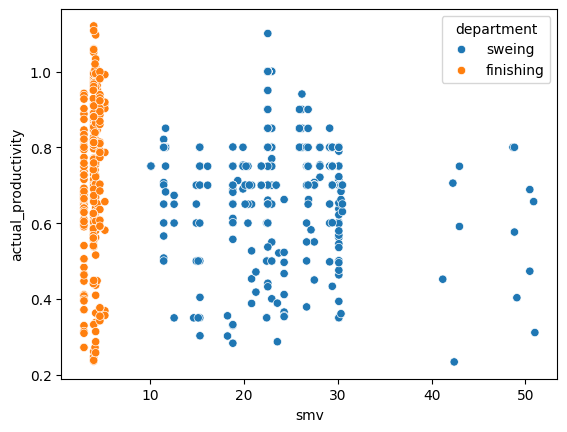

In [ ]:
sns.scatterplot(data = garments, y = 'actual_productivity', x = 'smv', hue = 'department')

<Axes: xlabel='targeted_productivity', ylabel='actual_productivity'>

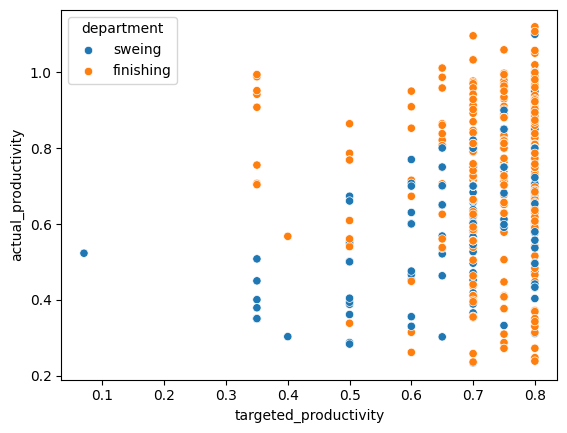

In [ ]:
sns.scatterplot(data = garments, y = 'actual_productivity', x = 'targeted_productivity', hue = 'department')

<Axes: xlabel='no_of_workers', ylabel='actual_productivity'>

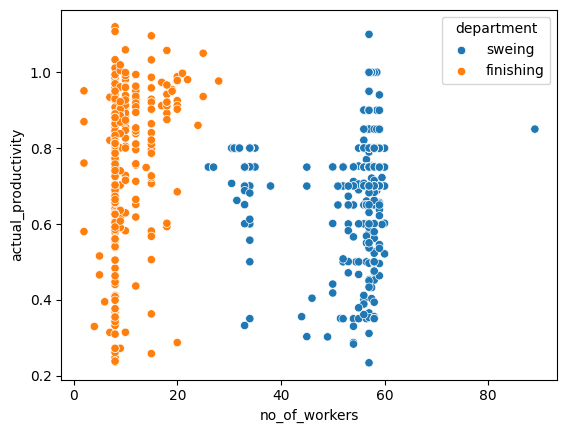

In [ ]:
sns.scatterplot(data = garments, y = 'actual_productivity', x = 'no_of_workers', hue = 'department')

Incentive and targeted productivity shows the clearest association. And this makes sense to me because higher incentive motivates workers to perform better, and higher managerial expectations also likely increases worker's productivity. The plot of SMV doesn't show as much of an association with productivity, but I still wanted to include it in my model because I believe the complexity (time required to finish) of a task would affect someone's productivity.

## Model 1 - incentive x productivity x smv

For my first model, I included incentive, productivity, and SMV as predictors and used a gamma likelihood

In [ ]:
#I combine all my predictor variables into one dataframe
X = garments[[
    'incentive',
    'targeted_productivity',
    'smv',
]]
Y = garments['actual_productivity'].to_numpy()

In [ ]:
with pm.Model() as model_garments:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_garments = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

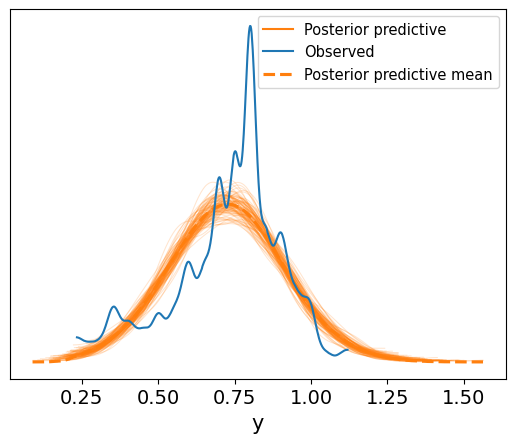

In [ ]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_garments,model_garments, extend_inferencedata=True)
az.plot_ppc(idata_garments, num_pp_samples=100, colors=["C1", "C0", "C1"])

My posterior predictive shows that the model doesn't fit very well. It isn't capturing the spike at the top, and the two ends of the curve also doesn't align with the observed. But, as Mr. A told me, this isn't horrible, and I could still look closer at each individual predictor to learn more.

## Ice Plots

array([<Axes: xlabel='incentive'>, <Axes: xlabel='targeted_productivity'>,
       <Axes: xlabel='smv'>], dtype=object)

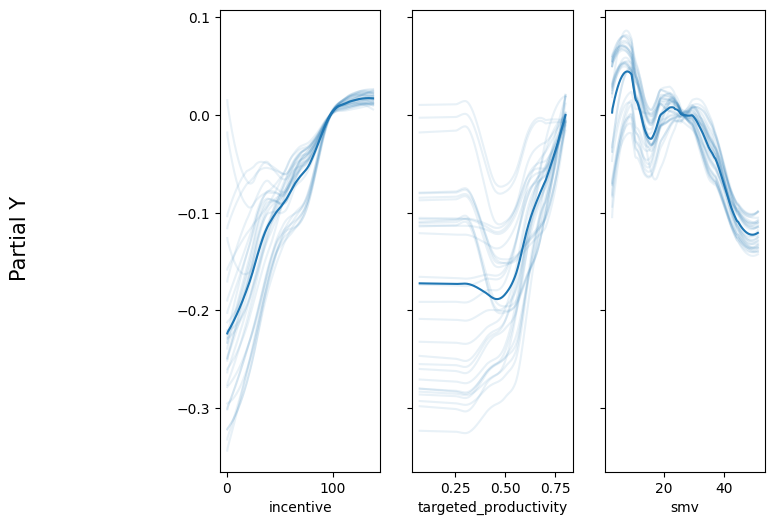

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

My ice plots show that incentive and targeted productivity are more stable for higher numbers. But for lower levels of targeted productivity (0-0.5), the trend varies a lot. This makes sense because with less strict expectations, workers can be more flexible, so some people could choose to work hard while others may not. Lower levels of incentive also show a bit of variance, and that could be due to the fact that some workers are intrinsically motivated while others are the opposite. SMV is more unstable overall, which might mean that it's interacting with other predictors like department and incentive, which results in varying relationships to productivity under each of those different contexts.

Additionally, we see that SMV has a nonlinear association with productivity. And low values of targeted productivity & high values of incentive also showed nonlinear associations.

## Variable Importance Plots

In [ ]:
vi_garments = pmb.compute_variable_importance(idata_garments, μ_, X)

<Axes: ylabel='R²'>

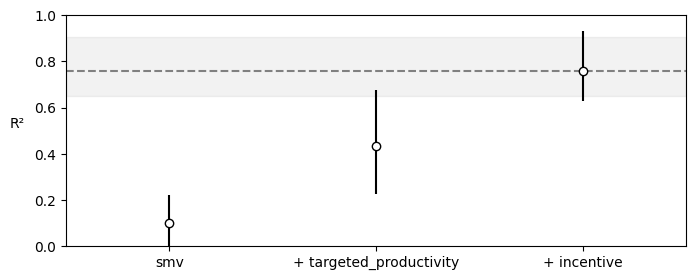

In [ ]:
pmb.plot_variable_importance(vi_garments)

My variable importance plot shows that targeted productivity boosts the model performance the most, since it contributes the biggest jump in R^2. SMV gave the least jump in R^2, and was also the most unstable in my ice plot, so that tells me I could probably leave it out in the next model and get a similar/better performance.

## Model 2 - Laplace Likelihood

For this model, I took out the SMV predictor and used a laplace likelihood.

In [5]:
#I combine all my predictor variables into one dataframe
X = garments[[
    'incentive',
    'targeted_productivity',
]]
Y = garments['actual_productivity'].to_numpy()

In [6]:
with pm.Model() as model_garments_laplace:
    b = pm.HalfNormal('b', sigma=1)
    μ_ = pmb.BART('μ_', X, np.log(Y), m=50)
    μ = pm.Deterministic('μ', pm.math.exp(μ_))
    y = pm.Laplace('y', mu=μ, b=b, observed=Y) #laplace likelihood
    idata_garments_laplace = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

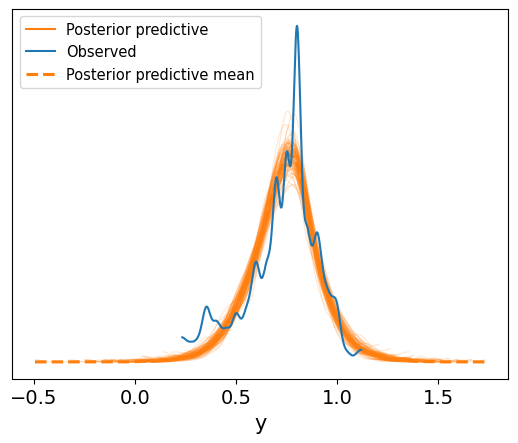

In [7]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_garments_laplace, model_garments_laplace, extend_inferencedata=True)
az.plot_ppc(idata_garments_laplace, num_pp_samples=100, colors=["C1", "C0", "C1"])

The fit is better. It still isn't capturing the spike at the top, but the posterior predictive lines up a lot better at the bottom. This is mostly due to changing the likelihood, but taking out SMV might have also helped.

array([<Axes: xlabel='incentive'>, <Axes: xlabel='targeted_productivity'>],
      dtype=object)

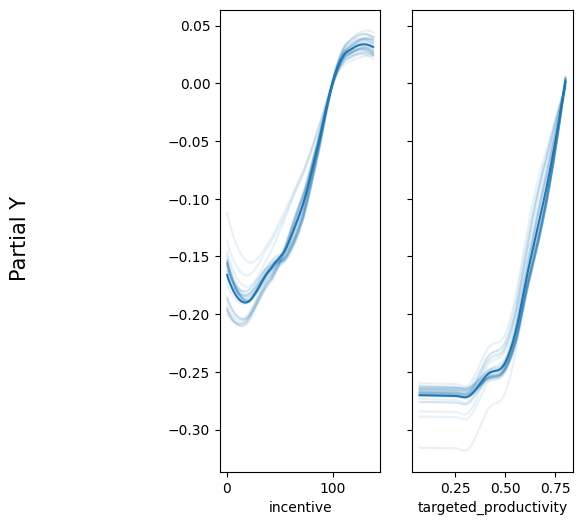

In [8]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

The ice plots of this model show more stability in these two predictors. I believe taking out SMV helped improve this, as it initially contributed a lot of complexity to our model. The posterior predictive still isn't great -- I could probably improve this model if I were able to explicitly define my interactions, but I'm unsure how to do that yet.